# Exercise 6: Supervised learning for 2D Ising model
Before working on this notebook, generate 2D Ising data at several temperatures and save it to file. You should have written a 2D Ising simulation by now, reuse that code. Else, you may adapt one of the solutions to carry out this task.

One possibility is to stringify a configuration by concatenating the rows, e.g. the configuration
<table>
  <tr>
    <td>1</td>
    <td>-1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>-1</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>1</td>
  </tr>
</table> 

could become the string "1 1 1 -1 1 1 1 -1 1". Then store all generated configurations in one file, and the temperatures corresponding to the different lines in a different file.

Generate "training" data from ~20 different temperatures, ~1000 configurations per temperature, and "verification" data from different (and potentially more) temperatures (also roughly 1000 configurations per temperature).

Think about whether it makes a difference how you represent the data (e.g. what if we concatenate the rows in a different order?).

# Imports

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob
import copy

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.models as models
import torchvision.transforms as transforms

import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

#from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report

n_workers = os.cpu_count()

# Loading the data

In [2]:
Nsample = 4000
L = 32

class CustomDataset(Dataset):

    def __init__(self):

        # make a list containing the path to all your csv files
        self.paths =  glob.glob('data/*/*.csv')

        # number of samples per csv file
        self.Nsample = Nsample
        self.L = L

        self.data = np.empty((self.Nsample, self.L**2), dtype=int)
        self.y = 0.0

        self.row_idx = 0
    
    def __len__(self):
        return len(self.paths)*self.Nsample

    def __getitem__(self, idx):
        T_c = 2.27
        
        self.row_idx = idx % self.Nsample

        #only load new file wenn all of the samples are load from same csv-file
        if self.row_idx == 0:
            self.data = np.loadtxt(self.paths[int(idx/self.Nsample)], skiprows=1, delimiter=',', dtype=int)
            T = np.loadtxt(self.paths[int(idx/self.Nsample)], max_rows=1)
            self.y = 1 if T < T_c else 0

        
        x = self.data[self.row_idx,:]

        x = x.reshape(self.L, self.L).astype(np.float32)

        return x, np.float32(self.y)

full_dataset = CustomDataset()
N = full_dataset.__len__()
#print(N)
#print(full_dataset.__getitem__(0))
#print(full_dataset[0][0])

train_dataset, val_dataset = random_split(full_dataset, [int(N*0.5), int(N*0.5)])
#print(train_dataset.__len__())
#print(test_dataset.__len__())

batch_size = 2048
full_dataloader  = DataLoader(full_dataset, batch_size = batch_size, shuffle = True, num_workers = n_workers)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = n_workers)
val_dataloader  = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = n_workers)

batch_transform = transforms.Compose([ transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()])

# Sanity check the data

In [3]:
def plot_configuration(spins):
    
    L = int(np.sqrt(spins.shape[0]))

    #spins = np.array(spins).reshape(L,L).astype(float)

    plt.imshow(spins)

    plt.axis('off')
    plt.show()

Feature batch shape: torch.float32
Labels batch shape: torch.float32


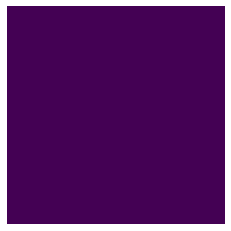

In [4]:
train_features, train_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {train_features.dtype}")
print(f"Labels batch shape: {train_labels.dtype}")

#print(train_features)
plot_configuration(train_features[0,:].numpy())

# Preprocessing the data
In order for the data to be usable in training, you need to
- Define a label coding. For an output layer with two neurons, you could code "ordered phase" as (1,0) and "disordered phase" as (0,1)
- Generate two arrays x and y, such that x contains all configurations and y the corresponding labels, e.g. from {(1,0), (0,1)}. The result should be that the correct label of the configuration x[i] is y[i].
- You may want to discard configurations close to the critical point (why?)

In [5]:
#TODO: Preprocess the data
#Not needed

# Construct and compile the network
Here you construct the neural network. Follow the link given on the exercise sheet.

Recommendation:
- One hidden layer with 100 neurons and sigmoid activation, fully connected
- Output layer with 2 neurons and softmax activation, fully connected

Feel free to play around with the network setup!

Finally, compile the network.

In [6]:
# Construct the model
class Classifier(pl.LightningModule):
    def __init__(self, bs=batch_size, batch_transform=None, train_dataset=train_dataset, val_dataset=val_dataset, lr=1e-4):
        super().__init__()
        
        #self.model = nn.Sequential(nn.Flatten(), nn.Linear(L*L, 128), nn.ReLU(), nn.Linear(128, 1), nn.Sigmoid())

        self.model = nn.Sequential(nn.Conv2d(1, 6, 5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2),
                                   nn.Conv2d(6, 16, 5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2),
                                   nn.Flatten(),
                                   nn.Linear(16 * 5 * 5, 120),
                                   nn.ReLU(),
                                   nn.Linear(120, 84),
                                   nn.ReLU(),
                                   nn.Linear(84, 1),
                                   nn.Sigmoid()
                                   )

        self.batch_size = bs

        self.batch_transform = batch_transform

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.loss_fct = nn.BCELoss()

        self.learning_rate=lr

        #self.accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        return self.loss_fct(y_hat, y)

    def show_model_arch(self):
      print(self.model.eval())

    def training_step(self, batch, batch_idx):
        x, y = batch

        
        if self.batch_transform:
            #x = self.batch_transform(x)
            x = torch.roll(x, np.random.randint(L), 1)
            x = torch.roll(x, np.random.randint(L), 2)
        
        x = x.unsqueeze(1)

        y_hat = self(x)
        y_hat = y_hat.squeeze(1)

        loss = self.compute_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        x = x.unsqueeze(1)

        y_hat = self(x)
        y_hat = y_hat.squeeze(1)

        loss = self.compute_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return  DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=n_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=n_workers) 

In [7]:
#model = models.alexnet()
#model.classifier = nn.Sequential(nn.Linear(4096,1), nn.Sigmoid())
#model = nn.Sequential(nn.Flatten(), nn.Linear(L*L, 128), nn.ReLU(), nn.Linear(128, 1), nn.Sigmoid())
#model.fc = nn.Sequential(nn.Linear(1024,1), nn.Sigmoid())
#print(model.eval())

# Train the network

In [8]:
# Train ('fit') the model. Experiment with number of epochs and batch sizes.
model = Classifier(batch_transform=batch_transform, train_dataset=train_dataset, val_dataset=val_dataset)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10, verbose=False, mode="min")


class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        each_me = copy.deepcopy(trainer.logged_metrics)
        self.metrics.append(each_me)

metrics_callback = MetricsCallback()

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

path = 'checkpoints/'
trainer = pl.Trainer(gpus=1, max_epochs=50, precision=32, auto_scale_batch_size=False, auto_lr_find=False, callbacks=[early_stop_callback, metrics_callback, checkpoint_callback], default_root_dir=path)
trainer.tune(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


{}

In [9]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | model    | Sequential | 60.9 K
1 | loss_fct | BCELoss    | 0     
----------------------------------------
60.9 K    Trainable params
0         Non-trainable params
60.9 K    Total params
0.244     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/80 [00:00<?, ?it/s]                       

/home/noah/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:406: UserWarning: The number of training samples (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 80/80 [00:10<00:00,  7.91it/s, loss=0.000514, v_num=2, train_loss=0.00022, val_loss=0.0385] 


In [10]:
#print best model and the val_loss it got
print(checkpoint_callback.best_model_path)
print(checkpoint_callback.best_model_score)

checkpoints/lightning_logs/version_2/checkpoints/epoch=39-step=1599.ckpt
tensor(0.0310, device='cuda:0')


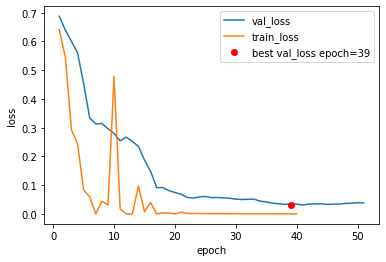

In [11]:
#plot the val_loss & train_loss
val_loss_list = []
train_loss_list = []
for metric in metrics_callback.metrics:
    for i in metric.items():
        if i[0] == 'val_loss':
            val_loss_list.append(i[1].cpu().numpy())
            #print(i[1].cpu().numpy())
        elif i[0] == 'train_loss':
            if torch.is_tensor(i[1]):
                train_loss_list.append(i[1].cpu().numpy())

plt.plot(range(1, len(val_loss_list)+1), val_loss_list, label="val_loss")
plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label="train_loss")

best_path = checkpoint_callback.best_model_path
for i in range(len(best_path)):
    if best_path[i:i+6] == "epoch=":
        try:
            best_epoch = int(best_path[i+6:i+8])
        except:
            best_epoch = int(best_path[i+6:i+7])
        break
plt.plot(best_epoch, checkpoint_callback.best_model_score.cpu().numpy(), "ro", label="best val_loss epoch=" + str(best_epoch))
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

# Predictions
Use your trained model to predict the phases of your "validation" configurations. Visualize the results.

For example, you could predict the phase of all configurations at a certain temperature T, then count how many are classified as "disordered" and how many as "ordered". Then plot this as a function of T.

In [12]:
#Perform predictions, visualize the results and interpret.
#load from best checkpoint
model = Classifier.load_from_checkpoint(checkpoint_callback.best_model_path)

model.eval()

Classifier(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=1, bias=True)
    (12): Sigmoid()
  )
  (loss_fct): BCELoss()
)

In [13]:
#accuracy train and val set
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    if next(model.parameters()).is_cuda:
        device = "cuda"
    else:
        device = "cpu"

    y_hat_all = torch.empty(0).to(device)
    y_all = torch.empty(0).to(device)
    
    test_loss, correct = 0, 0
    cnt_batches = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            X = X.unsqueeze(1)
            
            y_hat = model(X)
            y_hat = y_hat.squeeze(1)

            # print(y_hat.round())
            # print(y)
            # print(model.compute_loss(y_hat, y))
            # print((y_hat.round() == y).type(torch.float).sum().item())
            # break

            y_hat_all = torch.cat((y_hat_all, y_hat.round()))
            y_all     = torch.cat((y_all, y))

            test_loss += model.compute_loss(y_hat, y)
            correct += (y_hat.round() == y).type(torch.float).sum().item()

            cnt_batches += 1
            print(f"\r{cnt_batches*100.0/num_batches:>0.1f}%", end="", flush=True)

            

    test_loss /= num_batches
    correct /= size
    y_hat_all, y_all = y_hat_all.cpu().numpy(), y_all.cpu().numpy()
    print(f"\rTest Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f" Balanced Accuracy: ", balanced_accuracy_score(y_all, y_hat_all))
    print(f"\n Classification report:\n", classification_report(y_all, y_hat_all))

In [14]:
test(val_dataloader, model)

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.038395 

 Balanced Accuracy:  0.9164900157868089

 Classification report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     72323
         1.0       1.00      0.83      0.91      7677

    accuracy                           0.98     80000
   macro avg       0.99      0.92      0.95     80000
weighted avg       0.98      0.98      0.98     80000



In [15]:
test(train_dataloader, model)

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000564 

 Balanced Accuracy:  1.0

 Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     75992
         1.0       1.00      1.00      1.00      4008

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000

